In [1]:
# Import libraries
using Turing
using LinearAlgebra
using Distributions
using MultivariateStats
import MultivariateStats: reconstruct
using GaussianProcesses
using StatsBase
using Statistics
using Suppressor
using JLD2
using CSV
using DataFrames, DataFramesMeta
using SplitApplyCombine
using KernelFunctions
using MCMCChains
using PyCall
using PyPlot
using Printf
import PyCall.pyfunction


# Access the matplotlib module
matplotlib = pyimport("matplotlib")
seaborn = pyimport("seaborn")
os = pyimport("os")
pyimport("scienceplots")
np = pyimport("numpy")

plt.style.use(["default","science","no-latex"])
using StatsPlots

seaborn.color_palette("colorblind")

PyCall.pygui(:tk)

# Set a seed for reproducibility
using Random
Random.seed!(11);

FONTSIZE=20.5;

In [2]:
function tuple_to_idx(x,y)
    return ( (3*x - 3) + y )
end

tuple_to_idx (generic function with 1 method)

In [3]:
# function get_up_low(post_dict, upper_quant, lower_quant)
#     p = [upper_quant,lower_quant]
#     quantiles = zeros(19, 6, 2)
#     sorted_keys = sort(collect(keys(post_dict)))
#     for i in 1:19
#         mat = post_dict[ sorted_keys[i] ]
#         quantiles[i, 1,:] = quantile( mat[:,1], p )
#         quantiles[i, 2,:] = quantile( mat[:,2], p )
#         quantiles[i, 3,:] = quantile( mat[:,3], p )
#         quantiles[i, 4,:] = quantile( mat[:,4], p )
#         quantiles[i, 5,:] = quantile( mat[:,5], p )
#         quantiles[i, 6,:] = quantile( mat[:,6], p )
#     end
#     return quantiles
# end

function get_up_low(post_dict, upper_quant, lower_quant, γ0_is_log)
    p = [upper_quant,lower_quant]
    quantiles = zeros(19, 6, 2)
    sorted_keys = sort(collect(keys(post_dict)))
    # Adjust for when gamma_0 is considered on the log scale

        for i in 1:19
            mat = post_dict[ sorted_keys[i] ]
            quantiles[i, 1,:] = quantile( mat[:,1], p )
            quantiles[i, 2,:] = quantile( mat[:,2], p )
            quantiles[i, 3,:] = quantile( mat[:,3], p )
            quantiles[i, 4,:] = quantile( mat[:,4], p )
            quantiles[i, 5,:] = (γ0_is_log) ? quantile( np.log(mat[:,5]), p ) : quantile( mat[:,5], p )
            quantiles[i, 6,:] = quantile( mat[:,6], p )
        end

    return quantiles
end

get_up_low (generic function with 1 method)

In [14]:
present_day_post = np.load("../Data/Training_Data/posterior_samples_All_Combined.npy")
log_gamma = true
present_day_widths = zeros(6)

for i in 1:6
    present_day_widths[i] = (log_gamma && i ==5) ? quantile(np.log(present_day_post[:,i]), 0.95) - quantile(np.log(present_day_post[:,i]), 0.05) : quantile(present_day_post[:,i], 0.95) - quantile(present_day_post[:,i], 0.05)
end

In [15]:
#CHANGE THIS LINE TO WHERE THE POSTERIORS ARE LOCATED
path_to_posteriors = "../Data/Posterior_Data"

realizations = [i for i in 1:100];
total_widths = zeros(length(realizations),19,6)
sorted_keys = collect(range(2015,step=15,length=20))

#Plot each parameter's learning against last year observed, for each trajectory
for (iter, r) in enumerate(realizations)
    post = JLD2.load("$(path_to_posteriors)/R_$(r)_Posterior_Dict.jld2", "post_data")
    cred_int_90_up_low = get_up_low(post, 0.95, 0.05,log_gamma)
    for i in 1:2
        for j in 1:3
            var_idx = tuple_to_idx(i,j)
            # cred_int_90_upper = (var_idx == 5) ? log.(cred_int_90_up_low[:,var_idx,1]) : cred_int_90_up_low[:,var_idx,1]
            # cred_int_90_lower = (var_idx == 5) ? log.(cred_int_90_up_low[:,var_idx,2]) : cred_int_90_up_low[:,var_idx,2]
            cred_int_90_upper = cred_int_90_up_low[:,var_idx,1]
            cred_int_90_lower = cred_int_90_up_low[:,var_idx,2]
            widths = cred_int_90_upper .- cred_int_90_lower
            total_widths[iter, :, var_idx] = widths
        end
    end
end

un_cred_int_68_up_low = zeros(19,6,2)
for i in 1:19
    quant = [0.84, 0.16]
    for j in 1:6
        un_cred_int_68_up_low[i,j,:] = quantile(total_widths[:,i,j], quant)
    end
end

made it here
made it here
made it here
made it here
made it here
made it here
made it past main loop


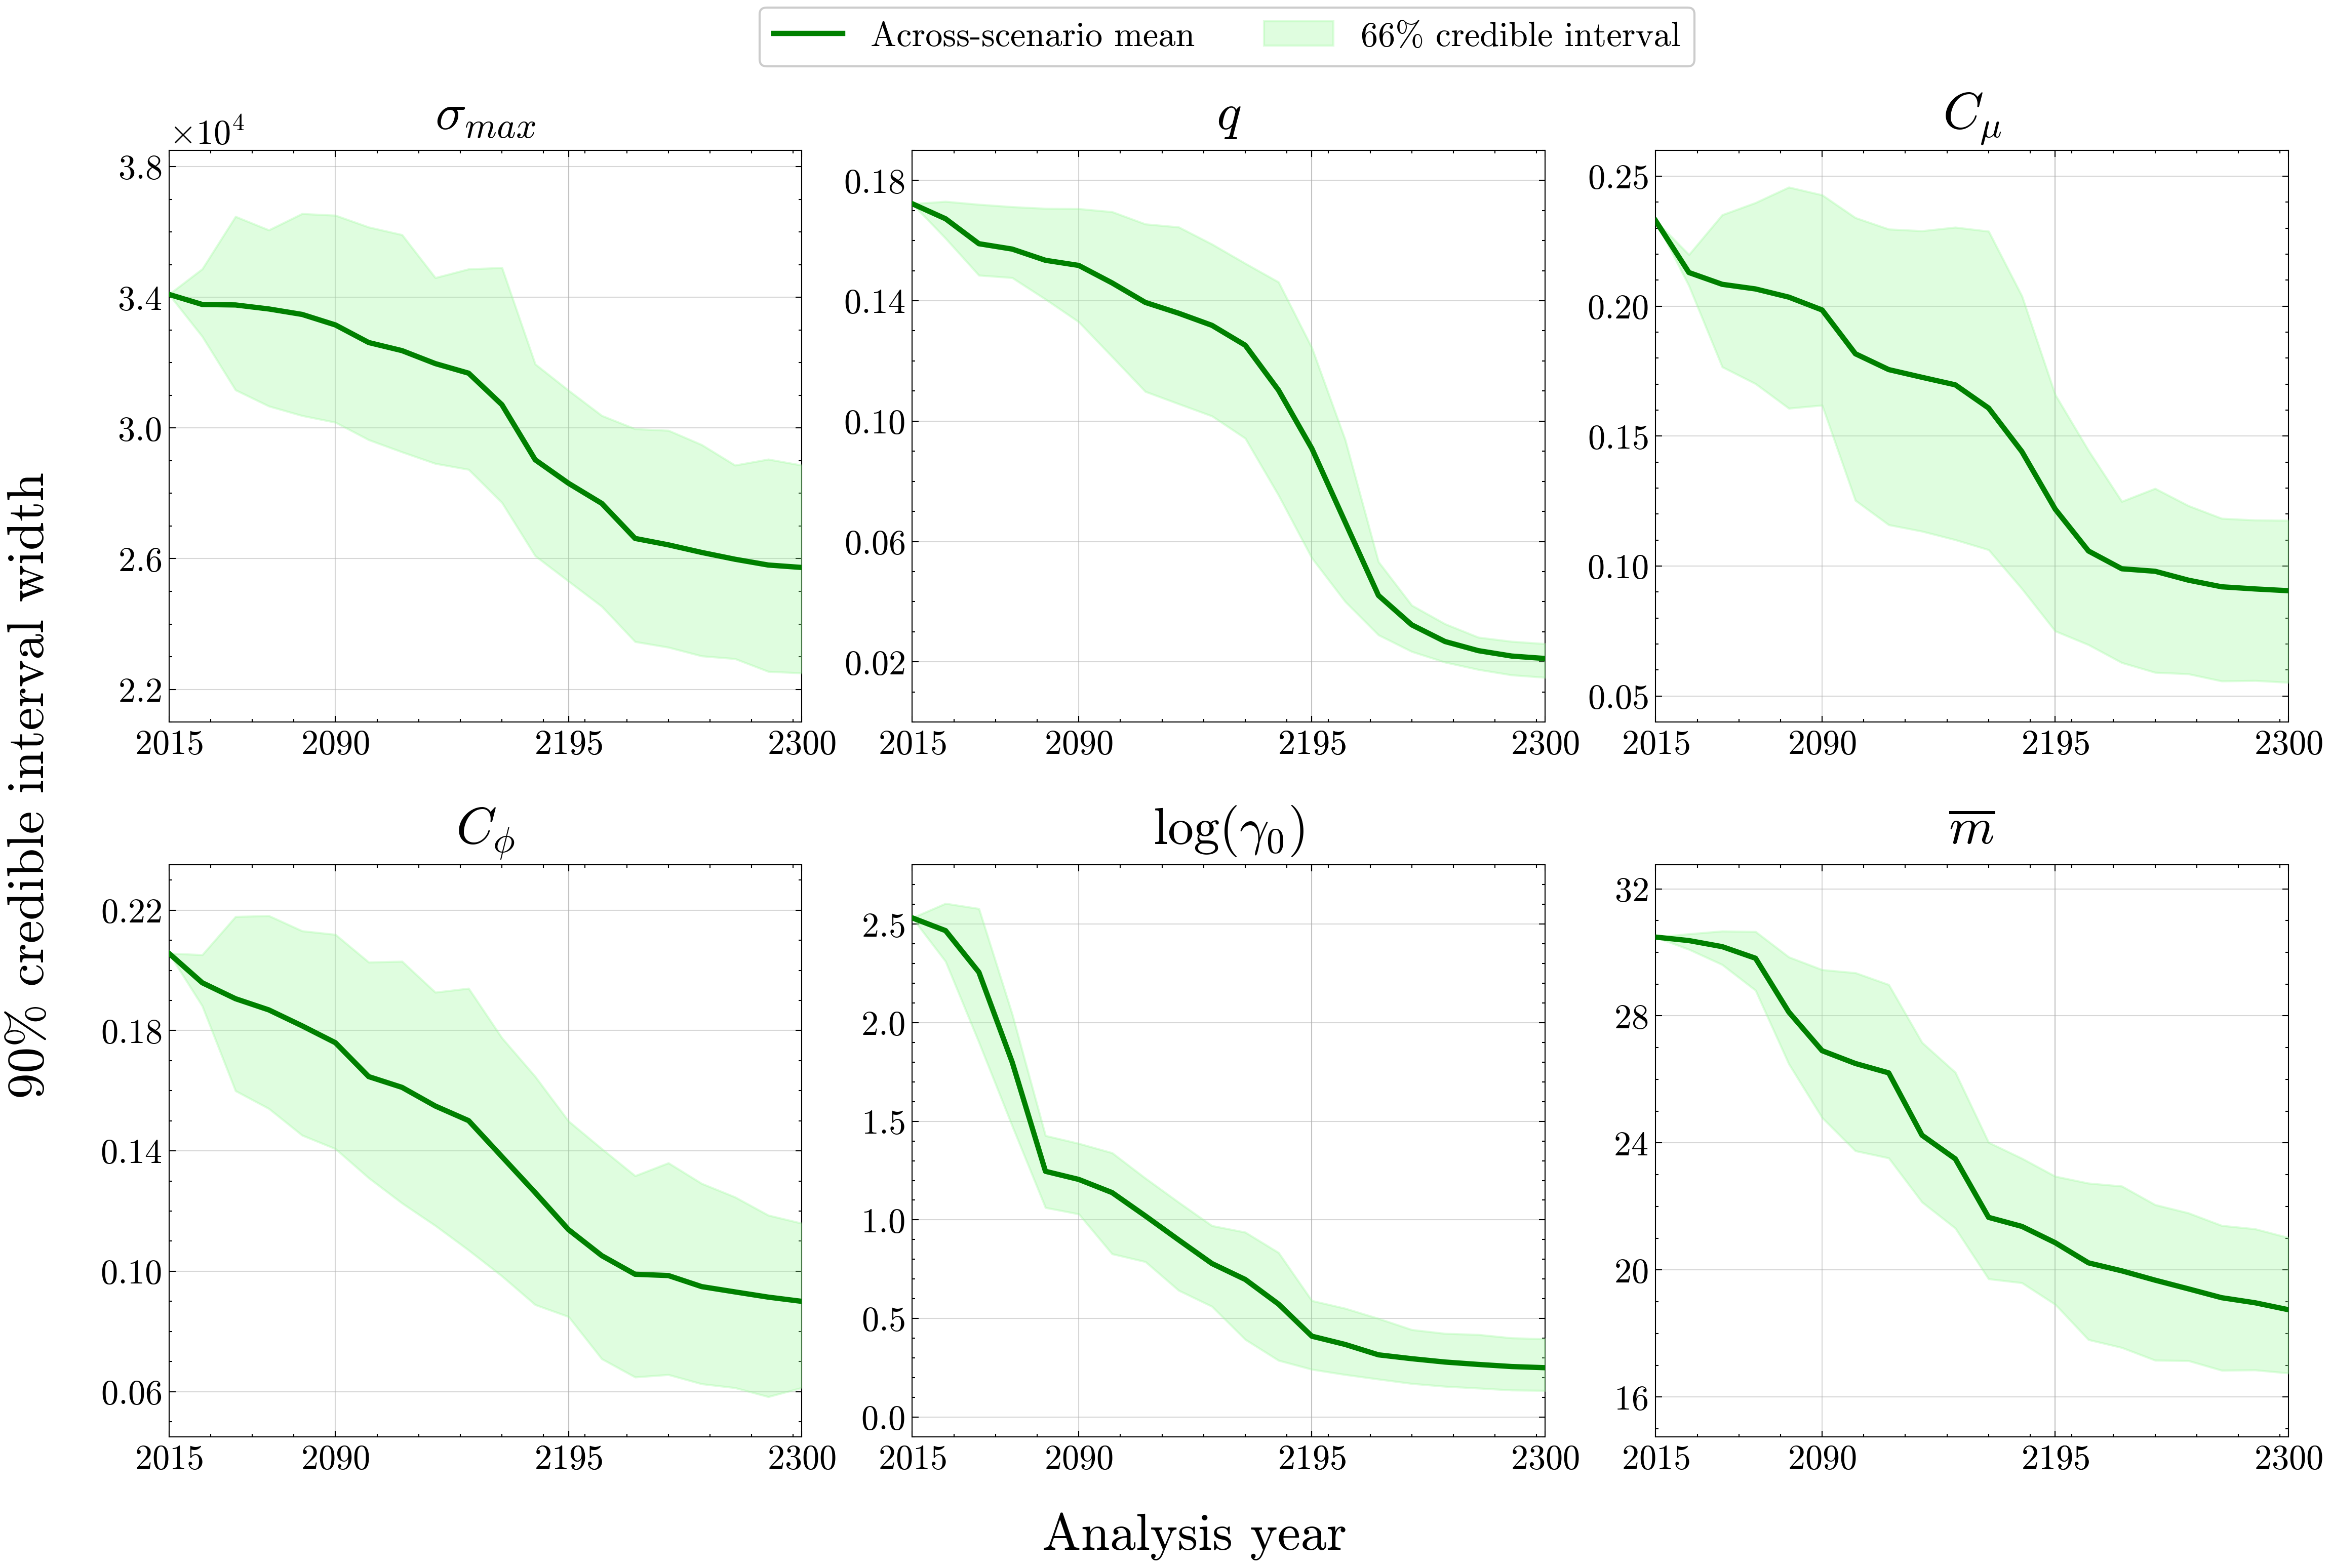

In [23]:
output_file_name = "../Plots/Parametric_Learning_Plots/parametric_learning_without_trajectories_test_new.pdf"

title_dict = Dict([
            1 => L"\sigma_{max}", 2 => L"q" , 3 => L"C_{\mu}" ,
            4 => L"C_{\phi}", 5 => L"\log(\gamma_0)", 6 => L"\overline{m}" ])

tick_dict  = Dict(1=>[22000,26000,30000,34000,38000],
                  2=>[0.02,0.06,0.10,0.14,0.18],
                  3=>[0.05,0.10,0.15,0.20,0.25],
                  4=>[0.06,0.10,0.14,0.18,0.22],
                  5=>[0.0,0.5,1.0,1.5,2.0,2.5,3.0],
                  6=>[16,20,24,28,32])

ylim_dict = Dict([1 => [2.1e4,3.85e4], 
                  2 => [0.00,0.19], 
                  3 => [0.04,0.26],
                  4 => [0.045,0.235], 
                  5 => [-0.1,2.8], 
                  6 => [14.75,32.75]])

selections = [13,26,39,44,49,70,78]

fig, ax = PyPlot.subplots(nrows=2, ncols=3, figsize=(18, 11), dpi=300,
                     gridspec_kw=Dict("height_ratios"=> [1, 1], "width_ratios" => [1, 1, 1],
                                    "wspace"=> 0.175, "hspace"=> 0.25))
FONTSIZE=20.5



#Plot each parameter's average learning across all the trajectories
for i in 1:2
    for j in 1:3
        var_idx = tuple_to_idx(i,j)
        current = total_widths[:,:,var_idx]
        mean_widths = vec(mean(current, dims=1))
        all_widths = vcat([present_day_widths[var_idx]],mean_widths)
        println("made it here")
        upper = un_cred_int_68_up_low[:,var_idx,1]
        lower = un_cred_int_68_up_low[:,var_idx,2]
        upper = vcat([present_day_widths[var_idx]], upper)
        lower = vcat([present_day_widths[var_idx]], lower)
        ax[i,j].plot(sorted_keys, all_widths, color="green",lw=2.5,label="Across-scenario mean", zorder = 601)
        ax[i,j].fill_between(sorted_keys, upper, lower, color="palegreen",alpha = 0.3, label="66% credible interval",zorder = 600)

        #UNCOMMENT LINE BELOW TO ADD TRAJECTORIES TO PLOTS
        # for iter in selections
        #     # ax[i,j].plot(sorted_keys, total_widths[iter, :, var_idx], marker = "o", markersize= 4, 
        #     #             label = iter == selections[1] ? "Individual scenario" : "_nolegend_",ls="dashed", 
        #     #             color = "black", markerfacecolor="green")
        # end
        
        ax[i,j].set_title(title_dict[var_idx],fontsize=1.2*FONTSIZE, pad=10)
        ax[i,j].ticklabel_format(style="sci", scilimits=(-2,4), useMathText=true)
        ax[i,j].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
        ax[i,j].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
        ax[i,j].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
        ax[i,j].set_yticks(tick_dict[var_idx])
        ax[i,j].set_ylim(ylim_dict[var_idx])
        ax[i,j].set_xlim([2015,2300])
        ax[i,j].set_xticks([2015,2090,2195,2195,2300])
        #ax[i,j].locator_params(tight=true, nbins=6)
        ax[i,j].grid(true, alpha=0.5, zorder=1)

    end
end
println("made it past main loop")
handles, labels = ax[1,1].get_legend_handles_labels()
n = length(handles)
desired_indices = filter(i -> 1 ≤ i ≤ n, [1,2,3]) 
sorted_handles = [handles[i] for i in desired_indices]
sorted_labels = [labels[i] for i in desired_indices]
fig.legend(sorted_handles, sorted_labels, loc="lower center", ncol=3, fontsize=0.8*FONTSIZE,
           bbox_to_anchor=(0.512, 0.92), bbox_transform=PyPlot.gcf().transFigure,
           frameon="True", framealpha=1)

fig.supxlabel("Analysis year", fontsize=FONTSIZE*1.2, y=0.036)
fig.supylabel("90% credible interval width", fontsize=FONTSIZE*1.2, x=0.066)

plt.savefig(output_file_name,dpi=300)